# Image Classification with stacked GoogleLeNet

This post builds on my two previous posts: [Convolutional neural network for image classification from scratch](http://machinememos.com/python/artificial%20intelligence/machine%20learning/cifar10/neural%20networks/convolutional%20neural%20network/dropout/image%20classification/2017/04/23/convolutional-neural-network-from-scratch.html) and [Image classification with pretrained CNN InceptionV3](http://machinememos.com/python/artificial%20intelligence/machine%20learning/cifar10/neural%20networks/convolutional%20neural%20network/googlelenet/inception/tensorflow/dropout/image%20classification/2017/05/04/cnn-image-classification-cifar-10-inceptionV3.html). In [Convolutional neural network for image classification from scratch](http://machinememos.com/python/artificial%20intelligence/machine%20learning/cifar10/neural%20networks/convolutional%20neural%20network/dropout/image%20classification/2017/04/23/convolutional-neural-network-from-scratch.html) I built a small convolutional neural network (CNN) to classify images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). My goal was to demonstrate how easy one can construct a neural network with descent accuracy (around 67%). Achieving an accuracy higher than that would required a deeper and wider neural network. Unfortunately, deeper and wider networks are often trained on multiple GPUs for several weeks. Hence, instead of training such a CNN from scrach in [Image classification with pretrained CNN InceptionV3](http://machinememos.com/python/artificial%20intelligence/machine%20learning/cifar10/neural%20networks/convolutional%20neural%20network/googlelenet/inception/tensorflow/dropout/image%20classification/2017/05/04/cnn-image-classification-cifar-10-inceptionV3.html) I showed how one could reuse an existing already pretrained one. Indeed, I used GoogleLeNet and more specifically the InceptionV3 neural network and applied some "finetuning" by training only the last few layers of the neural network. As a matter of fact, I was able to reach an accuracy that is significantly higher - 79,85%. In this post I want to try another approach. The goal is to achieve similar and possibly higher accuracy in much less time and without applying any finetuing. So, instead of retraining the last few layers, the neural network can be put in a classifier stack as a first level classifier, so that its output is the input of a second level classifier. Continue reading below for more details.

# Cifar-10 Image Dataset

If you are already familiar with any of my previous posts about convolutional neural networks - [Convolutional neural network for image classification from scratch](http://machinememos.com/python/artificial%20intelligence/machine%20learning/cifar10/neural%20networks/convolutional%20neural%20network/dropout/image%20classification/2017/04/23/convolutional-neural-network-from-scratch.html) or [Image classification with pretrained CNN InceptionV3](http://machinememos.com/python/artificial%20intelligence/machine%20learning/cifar10/neural%20networks/convolutional%20neural%20network/googlelenet/inception/tensorflow/dropout/image%20classification/2017/05/04/cnn-image-classification-cifar-10-inceptionV3.html), you might want to skip the next sections and go directly to **Stacking InceptionV3**.

The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60000 32x32 colour images in 10 categories - airplanes, dogs, cats, and other objects. The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. Here are the classes in the dataset, as well as 10 random images from each:
<img src="files/dataset_overview.jpg">
The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks.

## Download the dataset
First, few lines of code will download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [1]:
# DOWNLOAD DATASET 
from urllib.request import urlretrieve
import os
from tqdm import tqdm
import tarfile

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not os.path.isfile('cifar-10-python.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not os.path.isdir('cifar-10-batches-py'):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()

## Data Overview
The dataset is broken into batches - this is especially useful if one is to train the network on a laptop as it will probably prevent it from running out of memory. I only had 12 GB on mine and a single batch used around 3.2 GB - it wouldn't be possible to load everything at once. Nevertheless, the CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following:

* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

Understanding a dataset is part of making predictions on the data. Following functions can be used to view different images by changing the `batch_id` and `sample_id`. The `batch_id` is the id for a batch (1-5). The `sample_id` is the id for a image and label pair in the batch.

In [2]:
import pickle
import matplotlib.pyplot as plt

# The names of the classes in the dataset.
CLASS_NAMES = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]

def load_cfar10_batch(batch_id):

    with open(os.path.join('cifar-10-batches-py','data_batch_' 
              + str(batch_id)), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']

    return features, labels


def display_stats(features, labels, sample_id):

    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'
              .format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch {}:'.format(batch_id))
    print('Samples: {}'.format(len(features)))
    print('Label Counts: {}'.format(dict(zip(*np.unique(labels, return_counts=True)))))
    print('First 20 Labels: {}'.format(labels[:20]))

    sample_image = features[sample_id]
    sample_label = labels[sample_id]

    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, CLASS_NAMES[sample_label]))
    plt.axis('off')
    plt.imshow(sample_image)
    plt.show()

Let's check the first couple of images of each batch. The lines below can be easily modified to show an arbitary image from any batch.


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 0:
Image - Min Value: 0 Max Value: 255
Image - Shape: (32, 32, 3)
Label - Label Id: 6 Name: frog


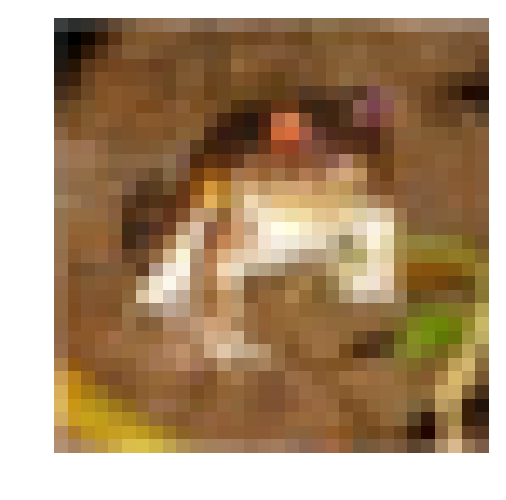


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 1:
Image - Min Value: 5 Max Value: 254
Image - Shape: (32, 32, 3)
Label - Label Id: 9 Name: truck


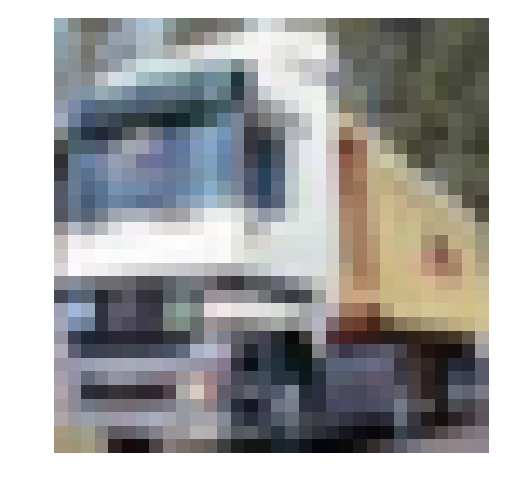


Stats of batch 2:
Samples: 10000
Label Counts: {0: 984, 1: 1007, 2: 1010, 3: 995, 4: 1010, 5: 988, 6: 1008, 7: 1026, 8: 987, 9: 985}
First 20 Labels: [1, 6, 6, 8, 8, 3, 4, 6, 0, 6, 0, 3, 6, 6, 5, 4, 8, 3, 2, 6]

Example of Image 0:
Image - Min Value: 5 Max Value: 225
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


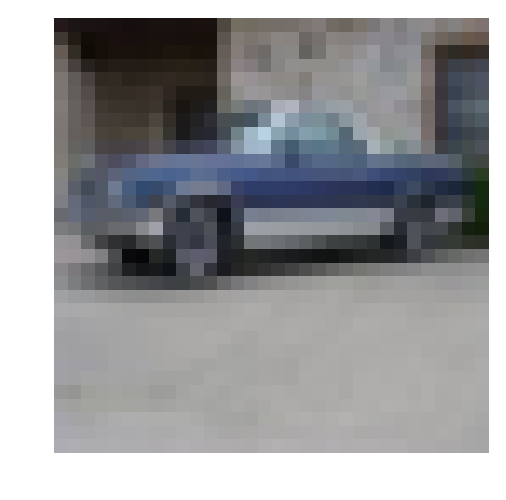


Stats of batch 2:
Samples: 10000
Label Counts: {0: 984, 1: 1007, 2: 1010, 3: 995, 4: 1010, 5: 988, 6: 1008, 7: 1026, 8: 987, 9: 985}
First 20 Labels: [1, 6, 6, 8, 8, 3, 4, 6, 0, 6, 0, 3, 6, 6, 5, 4, 8, 3, 2, 6]

Example of Image 1:
Image - Min Value: 2 Max Value: 247
Image - Shape: (32, 32, 3)
Label - Label Id: 6 Name: frog


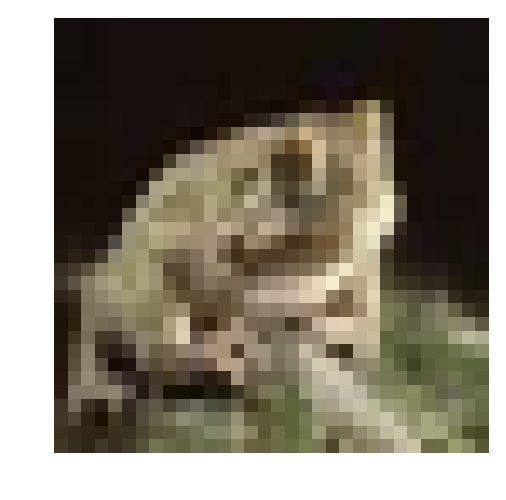


Stats of batch 3:
Samples: 10000
Label Counts: {0: 994, 1: 1042, 2: 965, 3: 997, 4: 990, 5: 1029, 6: 978, 7: 1015, 8: 961, 9: 1029}
First 20 Labels: [8, 5, 0, 6, 9, 2, 8, 3, 6, 2, 7, 4, 6, 9, 0, 0, 7, 3, 7, 2]

Example of Image 0:
Image - Min Value: 0 Max Value: 254
Image - Shape: (32, 32, 3)
Label - Label Id: 8 Name: ship


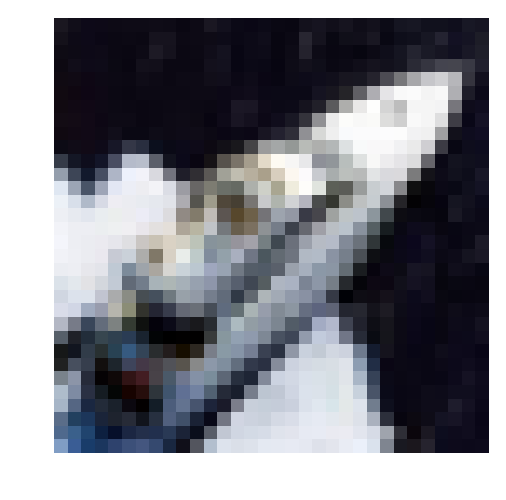


Stats of batch 3:
Samples: 10000
Label Counts: {0: 994, 1: 1042, 2: 965, 3: 997, 4: 990, 5: 1029, 6: 978, 7: 1015, 8: 961, 9: 1029}
First 20 Labels: [8, 5, 0, 6, 9, 2, 8, 3, 6, 2, 7, 4, 6, 9, 0, 0, 7, 3, 7, 2]

Example of Image 1:
Image - Min Value: 15 Max Value: 249
Image - Shape: (32, 32, 3)
Label - Label Id: 5 Name: dog


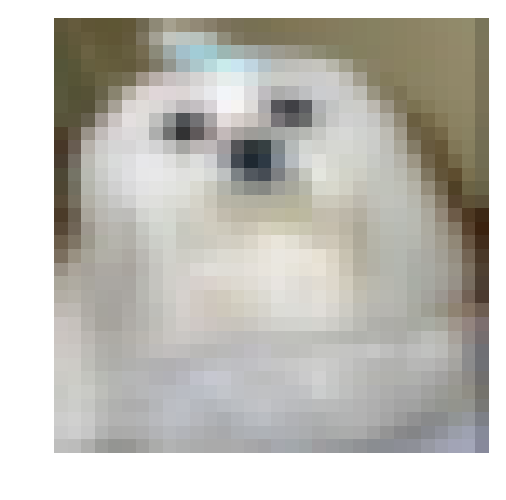


Stats of batch 4:
Samples: 10000
Label Counts: {0: 1003, 1: 963, 2: 1041, 3: 976, 4: 1004, 5: 1021, 6: 1004, 7: 981, 8: 1024, 9: 983}
First 20 Labels: [0, 6, 0, 2, 7, 2, 1, 2, 4, 1, 5, 6, 6, 3, 1, 3, 5, 5, 8, 1]

Example of Image 0:
Image - Min Value: 34 Max Value: 203
Image - Shape: (32, 32, 3)
Label - Label Id: 0 Name: airplane


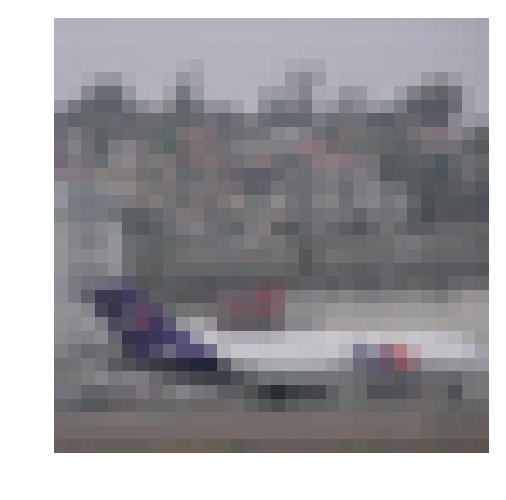


Stats of batch 4:
Samples: 10000
Label Counts: {0: 1003, 1: 963, 2: 1041, 3: 976, 4: 1004, 5: 1021, 6: 1004, 7: 981, 8: 1024, 9: 983}
First 20 Labels: [0, 6, 0, 2, 7, 2, 1, 2, 4, 1, 5, 6, 6, 3, 1, 3, 5, 5, 8, 1]

Example of Image 1:
Image - Min Value: 0 Max Value: 246
Image - Shape: (32, 32, 3)
Label - Label Id: 6 Name: frog


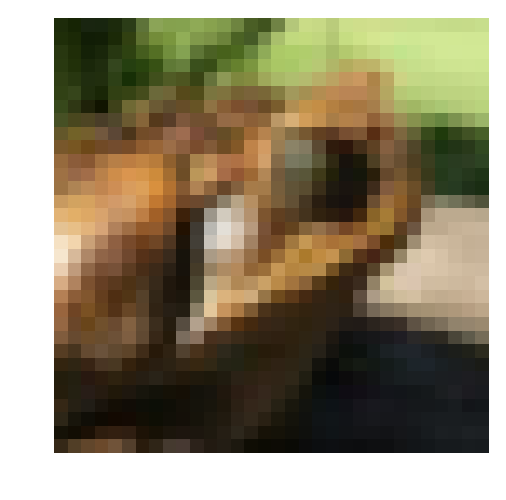


Stats of batch 5:
Samples: 10000
Label Counts: {0: 1014, 1: 1014, 2: 952, 3: 1016, 4: 997, 5: 1025, 6: 980, 7: 977, 8: 1003, 9: 1022}
First 20 Labels: [1, 8, 5, 1, 5, 7, 4, 3, 8, 2, 7, 2, 0, 1, 5, 9, 6, 2, 0, 8]

Example of Image 0:
Image - Min Value: 2 Max Value: 255
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


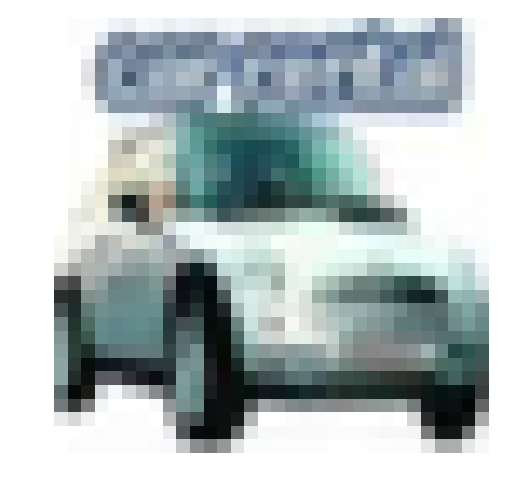


Stats of batch 5:
Samples: 10000
Label Counts: {0: 1014, 1: 1014, 2: 952, 3: 1016, 4: 997, 5: 1025, 6: 980, 7: 977, 8: 1003, 9: 1022}
First 20 Labels: [1, 8, 5, 1, 5, 7, 4, 3, 8, 2, 7, 2, 0, 1, 5, 9, 6, 2, 0, 8]

Example of Image 1:
Image - Min Value: 1 Max Value: 244
Image - Shape: (32, 32, 3)
Label - Label Id: 8 Name: ship


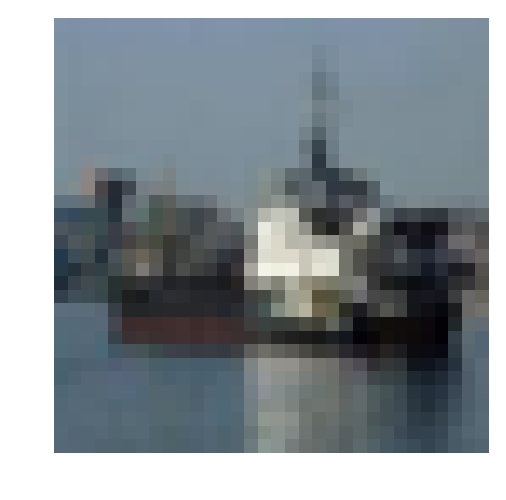

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

for batch_id in range(1,6):
    features, labels = load_cfar10_batch(batch_id)
    for image_id in range(0,2):
        display_stats(features, labels, image_id)

del features, labels # free memory  

# Converting datasets to .tfrecord
Next we convert the datasets to tfrecords. This would allow for the easier further processing by Tensorflow. While the neural network constructed in [Convolutional neural network for image classification from scratch](http://machinememos.com/python/artificial%20intelligence/machine%20learning/cifar10/neural%20networks/convolutional%20neural%20network/dropout/image%20classification/2017/04/23/convolutional-neural-network-from-scratch.html) expected images with size 32x32, the CNN we are going to use here expects an input size of 299x299. Nevertheless, it is not necessary to convert all 60000 images to the target size of 299x299 as this would requre much more of your disk space. Converting the data to tfrecord would actually shrink the dataset size (lossless compression) and allow for the use of tensorflow's preprocessing pipeline and a dynamic conversion to the desired target size of 299x299 at training time.

In [4]:
import sys
import dataset_utils
import tensorflow as tf

IMAGE_SIZE = 32
RGB_CHANNELS = 3

def add_to_tfrecord(filename, tfrecord_writer, offset=0):
    
    with open(filename, mode='rb') as f:
        data = pickle.load(f, encoding='latin1')
    
    images = data['data']
    num_images = images.shape[0]

    images = images.reshape((num_images, RGB_CHANNELS, IMAGE_SIZE, IMAGE_SIZE))
    labels = data['labels']

    with tf.Graph().as_default():
        image_placeholder = tf.placeholder(dtype=tf.uint8)
        encoded_image = tf.image.encode_png(image_placeholder)

        with tf.Session('') as sess:

            for j in range(num_images):
                sys.stdout.write('\r>> Reading file [%s] image %d/%d' % \
                    (filename, offset + j + 1, offset + num_images))
                sys.stdout.flush()

                image = np.squeeze(images[j]).transpose((1, 2, 0))
                label = labels[j]

                png_string = sess.run(encoded_image,\
                         feed_dict={image_placeholder: image})

                example = dataset_utils.image_to_tfexample(\
                    png_string, 'png'.encode('utf-8'), IMAGE_SIZE, IMAGE_SIZE, label)
                tfrecord_writer.write(example.SerializeToString())

    return offset + num_images


if not os.path.isdir('tfrecord'):
    # make the directory
    os.mkdir('tfrecord')
    # write all 5 batches into single training tfrecord
    with tf.python_io.TFRecordWriter(os.path.join('tfrecord', 'cifar-10-training-tfrecord')) as tfrecord_writer:
        offset = 0
        for i in range(1, 6): # Train batches are data_batch_1 ... data_batch_5
            filename = os.path.join('cifar-10-batches-py', 'data_batch_%d' % (i))
            offset = add_to_tfrecord(filename, tfrecord_writer, offset)

    # Next, process the testing data:
    with tf.python_io.TFRecordWriter(os.path.join('tfrecord', 'cifar-10-test-tfrecord')) as tfrecord_writer:
        filename = os.path.join('cifar-10-batches-py', 'test_batch')
        add_to_tfrecord(filename, tfrecord_writer)

    # Finally, write the labels file:
    labels_to_class_names = dict(zip(range(len(CLASS_NAMES)), CLASS_NAMES))

    with tf.gfile.Open(os.path.join('tfrecord', 'labels.txt'), 'w') as f:
        for label in labels_to_class_names:
            class_name = labels_to_class_names[label]
            f.write('%d:%s\n' % (label, class_name))

# Downloading GoogleLeNet
Check my previous post [Image classification with pretrained CNN InceptionV3](http://machinememos.com/python/artificial%20intelligence/machine%20learning/cifar10/neural%20networks/convolutional%20neural%20network/googlelenet/inception/tensorflow/dropout/image%20classification/2017/05/04/cnn-image-classification-cifar-10-inceptionV3.html) for information on why InceptionV3 has been selected.

In [5]:
inceptionv3_archive = os.path.join('model', 'inception_v3_2016_08_28.tar.gz')

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not os.path.isdir('model'):
    # create directory to store model
    os.mkdir('model')
    # download the model
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='InceptionV3') as pbar:
        urlretrieve(
            # I hope this url stays there
            'http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz',
            inceptionv3_archive,
            pbar.hook)

    with tarfile.open(inceptionv3_archive) as tar:
        tar.extractall('model')
        tar.close()

Next we define a couple of utility functions for loading a batch and loading the dataset... 

In [6]:
import inception_preprocessing

def load_batch(dataset, batch_size, height, width, is_training=False):
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32, common_queue_min=8)
    image_raw, label = data_provider.get(['image', 'label'])
    
    # Preprocess image for usage by Inception.
    image = inception_preprocessing.preprocess_image(
        image_raw, height, width, is_training=is_training)
    
    # Preprocess the image for display purposes.
    image_raw = tf.expand_dims(image_raw, 0)
    image_raw = tf.image.resize_images(image_raw, [height, width])
    image_raw = tf.squeeze(image_raw)

    # Batch it up.
    images, images_raw, labels = tf.train.batch(
          [image, image_raw, label],
          batch_size=batch_size,
          num_threads=1,
          capacity=2 * batch_size)
    
    return images, images_raw, labels

def get_dataset(dataset_file_name, train_sample_size):

    ITEMS_TO_DESCRIPTIONS = {
        'image': 'A [32 x 32 x 3] color image.',
        'label': 'A single integer between 0 and 9',
    }

    keys_to_features = {
          'image/encoded': tf.FixedLenFeature((), tf.string, default_value=''),
          'image/format': tf.FixedLenFeature((), tf.string, default_value='png'),
          'image/class/label': tf.FixedLenFeature(
              [], tf.int64, default_value=tf.zeros([], dtype=tf.int64)),
    }

    items_to_handlers = {
          'image': slim.tfexample_decoder.Image(shape=[IMAGE_SIZE, IMAGE_SIZE, 3]),
          'label': slim.tfexample_decoder.Tensor('image/class/label'),
    }

    labels_to_names = {}
    for i in range(0, len(CLASS_NAMES)):
        labels_to_names[i] = CLASS_NAMES[i]

    decoder = slim.tfexample_decoder.TFExampleDecoder(keys_to_features, items_to_handlers)

    return slim.dataset.Dataset(
          data_sources=dataset_file_name,
          reader=tf.TFRecordReader,
          decoder=decoder,
          num_samples=train_sample_size,
          items_to_descriptions=ITEMS_TO_DESCRIPTIONS,
          num_classes=len(CLASS_NAMES),
          labels_to_names=labels_to_names)

# Stacking InceptionV3
So instead of finetuning the neural network like we did in [Image classification with pretrained CNN InceptionV3](http://machinememos.com/python/artificial%20intelligence/machine%20learning/cifar10/neural%20networks/convolutional%20neural%20network/googlelenet/inception/tensorflow/dropout/image%20classification/2017/05/04/cnn-image-classification-cifar-10-inceptionV3.html), we are going to use it as a first level classifier in a stack of classifiers consisting of two levels. In the code below the InceptionV3 model is loaded and without any training whatsover it is used to make a prediction for all images in the training set. Note that the unmodified InceptionV3 model has an output that is a vector of length 1001. For each image this output vector is saved to be later used as un input for the second level classifier. 

In [11]:
from inception_v3 import inception_v3
from inception_v3 import inception_v3_arg_scope
from tqdm import tqdm

BATCH_SIZE = 50
TRAIN_SAMPLES = 50000
NUMBER_OF_STEPS = int(TRAIN_SAMPLES / BATCH_SIZE)
INCEPTION_OUTPUT_SIZE = 1001

INCEPTION_IMAGE_SIZE = 299

slim = tf.contrib.slim

meta_data_train_X = []
meta_data_train_Y = []

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.ERROR)
    
    train_dataset = get_dataset(
        os.path.join('tfrecord','cifar-10-training-tfrecord'), TRAIN_SAMPLES)
    images, images_raw, labels = load_batch(
        train_dataset, BATCH_SIZE, INCEPTION_IMAGE_SIZE, INCEPTION_IMAGE_SIZE)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception_v3_arg_scope()):
        logits, _ = inception_v3(images, num_classes=INCEPTION_OUTPUT_SIZE, is_training=False)

    probabilities = tf.nn.softmax(logits)
    
    init_fn = slim.assign_from_checkpoint_fn(
        os.path.join('model','inception_v3.ckpt'), slim.get_model_variables())
    
    with tf.Session() as sess:
        with slim.queues.QueueRunners(sess):
            sess.run(tf.initialize_local_variables())
            init_fn(sess)
            for i in tqdm(range(NUMBER_OF_STEPS)):
                np_probabilities, np_images_raw, np_labels = sess.run([probabilities, images_raw, labels])
                meta_data_train_X += np_probabilities.tolist()
                meta_data_train_Y += np_labels.tolist()

Instructions for updating:
Use `tf.local_variables_initializer` instead.


100%|██████████| 1000/1000 [3:00:56<00:00, 10.95s/it] 


It does not hurt to save the outputs to the disk in case the python notebook kernel crashes...

In [12]:
import pickle

assert len(meta_data_train_X) == TRAIN_SAMPLES
assert len(meta_data_train_Y) == TRAIN_SAMPLES

with open('meta_data_train_inceptionV3.p', 'wb') as handle:
    pickle.dump((meta_data_train_X, meta_data_train_Y), handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('meta_data_train_inceptionV3.p', 'rb') as handle:
    meta_data_train_X, meta_data_train_Y = pickle.load(handle)

Once training data set goes through the InceptionV3 network, you are all set to use the output vectors that have been produced as a training set for a second level classifier, Hence, your next task is to choose the second level classifier. As an input it receives the output vectors created by the unmodified InceptionV3 neural network. Its output, however, is the actual label - an integer from 1 to 10 for the 10 categories in the cifar-10 dataset. Below I will train three different second level classifiers in order to compare their performance. I will start with the most simple classifier possible, linear regression with L2 regularisation, that is also known as [ridge regression classifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html). It is not a bad idea to use a 5-fold cross validation in order to evaluate the classifier's accuracy without actually using the test set.

In [55]:
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score

ridge_classifier = RidgeClassifier(alpha=1e-5)
scores = cross_val_score(ridge_classifier, meta_data_train_X, meta_data_train_Y, cv=5)

print('Accuracy ridge classifier', np.mean(scores))

Accuracy ridge classifier 0.743219828872


With an accuracy of over 74% it is already better than the accuracy achieved in my home made, small and simple CNN described in [Convolutional neural network for image classification from scratch](http://machinememos.com/python/artificial%20intelligence/machine%20learning/cifar10/neural%20networks/convolutional%20neural%20network/dropout/image%20classification/2017/04/23/convolutional-neural-network-from-scratch.html). Let's train the ridge regression on the whole training set, it only takes a few seconds...

In [77]:
ridge_classifier = RidgeClassifier(alpha=1e-5).fit(meta_data_train_X, meta_data_train_Y)

The second second-level classifier I want to evaluate is a small fully connected neural network. We can split the training set into training (90%) and validation (10%) parts in order to test the classifier's performance without actually using the test set. To keep it short and simple, I will use the [TensorFlow’s high-level machine learning API (tf.contrib.learn)](https://www.tensorflow.org/get_started/tflearn). The neural network below has an input layer of 1001 nodes (that is the output of Inception3), and three hidden layers of 2048, 512 and 64 nodes.

In [75]:
train_X, train_Y = np.array(meta_data_train_X[:45000], dtype=np.float32), meta_data_train_Y[:45000]
validation_X, validation_Y = np.array(meta_data_train_X[45000:], dtype=np.float32), meta_data_train_Y[45000:]

tf.logging.set_verbosity(tf.logging.ERROR)
feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(train_X)
dnnClassifier = tf.contrib.learn.DNNClassifier(hidden_units=[2048, 512, 64],
                                            feature_columns=feature_columns,  
                                            n_classes=10,
                                            model_dir='second_leveld_dnn',
                                            dropout=0.2,
                                            optimizer=tf.train.AdamOptimizer(learning_rate=0.001))

for i in tqdm(range(10)):
    classifier.fit(x=train_X, y=train_Y, steps=50)
    accuracy_score = classifier.evaluate(x=validation_X, y=validation_Y, steps=1)["accuracy"]
    print('Accuracy DNNClassifier',accuracy_score)


  0%|          | 0/10 [00:00<?, ?it/s]/home/freeman/anaconda3/envs/machinelearning/lib/python3.5/site-packages/tensorflow/python/util/deprecation.py:247: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b

 10%|█         | 1/10 [10:48<1:37:14, 648.28s/it]

Accuracy DNNClassifier 0.7536


 20%|██        | 2/10 [21:47<1:26:52, 651.62s/it]

Accuracy DNNClassifier 0.7772


 30%|███       | 3/10 [33:02<1:16:50, 658.59s/it]

Accuracy DNNClassifier 0.7888


 40%|████      | 4/10 [43:58<1:05:47, 657.90s/it]

Accuracy DNNClassifier 0.797


 50%|█████     | 5/10 [54:30<54:10, 650.17s/it]  

Accuracy DNNClassifier 0.8022


 60%|██████    | 6/10 [1:05:08<43:05, 646.26s/it]

Accuracy DNNClassifier 0.8062


 70%|███████   | 7/10 [1:16:01<32:25, 648.52s/it]

Accuracy DNNClassifier 0.808


 80%|████████  | 8/10 [1:27:10<21:49, 654.67s/it]

Accuracy DNNClassifier 0.8082


 90%|█████████ | 9/10 [1:38:04<10:54, 654.31s/it]

Accuracy DNNClassifier 0.8072


100%|██████████| 10/10 [1:48:54<00:00, 653.14s/it]

Accuracy DNNClassifier 0.808


The accuracy goes up to almost 81%. However, a little more then a few seconds are needed. It took almost 2 hours on my laptop. And then we need another two hours to train it on the whole training set... I will be gearing up with several GPUs in the next few weeks.

In [91]:
tf.logging.set_verbosity(tf.logging.ERROR)
feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(train_X)
dnnClassifier = tf.contrib.learn.DNNClassifier(hidden_units=[2048, 512, 64],
                                            feature_columns=feature_columns,  
                                            n_classes=10,
                                            model_dir='full_second_leveld_dnn',
                                            dropout=0.2,
                                            optimizer=tf.train.AdamOptimizer(learning_rate=0.001))
for i in tqdm(range(10)):
    dnnClassifier.fit(x= np.array(meta_data_train_X, dtype=np.float32), y=meta_data_train_Y, steps=50)


  0%|          | 0/10 [00:00<?, ?it/s]/home/freeman/anaconda3/envs/machinelearning/lib/python3.5/site-packages/tensorflow/python/util/deprecation.py:247: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b

100%|██████████| 10/10 [2:11:16<00:00, 749.81s/it] 


At last, I want to also evaluate one more classifier. This one is actually one of mine and many AI engineers favorite - the Boosted Trees classifier and its implementation [xgboost](http://xgboost.readthedocs.io/en/latest/model.html). It became widly popular as it was consistently used in the winning solutions for many of the challenges posted on [kaggle](http://xgboost.readthedocs.io/en/latest/model.html). Interesting enoughs, several challenges has been won by using only feature engineering and stacking xgboost classifier on top of each other... Sadly, you can not really classify images with Boosted Trees, but you can sure use them as a second level classifier.

In [56]:
import xgboost

xgb_classifier = xgboost.XGBClassifier(learning_rate=0.1,
 n_estimators=100,
 max_depth=4)

X = np.array(meta_data_train_X)

scores = cross_val_score(xgb_classifier,  np.array(meta_data_train_X), np.array(meta_data_train_Y), cv=5, verbose=True)
print('Accuracy xgboost', np.mean(scores))

Accuracy xgboost 0.823939567637


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 71.9min finished


In a 5-fold cross validation set it yelds the best accuracy so far more than 82%. It also needs a little less time than the fully connected neural network above. Let's train it on the whole training set. 

In [76]:
# Prepare classifier
xgb_classifier = xgboost.XGBClassifier(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=4).fit(np.array(meta_data_train_X), np.array(meta_data_train_Y))

# Evaluation
At last it is time to evaluate our two level stack. First, we move all the images from the test set through the neural network to create the output of the first layer of our two layer stack. That output we are then to feed into each of the second level classifiers in order to get the final predictions.

In [78]:
TEST_SAMPLES = 10000
BATCH_SIZE = 50
NUMBER_OF_STEPS = int(TEST_SAMPLES / BATCH_SIZE)

meta_data_test_X = []
meta_data_test_Y = []

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.ERROR)
    
    test_dataset = get_dataset(
        os.path.join('tfrecord','cifar-10-test-tfrecord'), TEST_SAMPLES)
    images, images_raw, labels = load_batch(
        test_dataset, BATCH_SIZE, INCEPTION_IMAGE_SIZE, INCEPTION_IMAGE_SIZE)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception_v3_arg_scope()):
        logits, _ = inception_v3(images, num_classes=INCEPTION_OUTPUT_SIZE, is_training=False)

    probabilities = tf.nn.softmax(logits)
    
    init_fn = slim.assign_from_checkpoint_fn(
        os.path.join('model','inception_v3.ckpt'), slim.get_model_variables())
    
    with tf.Session() as sess:
        with slim.queues.QueueRunners(sess):
            sess.run(tf.initialize_local_variables())
            init_fn(sess)
            for i in tqdm(range(NUMBER_OF_STEPS)):
                np_probabilities, np_images_raw, np_labels = sess.run([probabilities, images_raw, labels])
                meta_data_test_X += np_probabilities.tolist()
                meta_data_test_Y += np_labels.tolist()

Instructions for updating:
Use `tf.local_variables_initializer` instead.


100%|██████████| 200/200 [38:55<00:00, 10.25s/it] 


Ok, now the outputs are used as inputs in the three classifiers - ridge regression, fully connected NN and xgboost. The final accuracy is then calculated for each of the three classifiers.

In [97]:
from sklearn.metrics import accuracy_score
# Accuracy of Ridge Regression as second level classifier, evaluated on the test set
predictions_ridge = ridge_classifier.predict(meta_data_test_X)
print('Accuracy with RidgeRegression as second level classifier', accuracy_score(predictions_ridge, meta_data_test_Y))
prediction_dnn = dnnClassifier.predict_classes(x=np.array(meta_data_test_X))
print('Accuracy with Deep Neural Network as second level classifier', accuracy_score(list(prediction_dnn), meta_data_test_Y))
prediction_xgb = xgb_classifier.predict(np.array(meta_data_test_X))
print('Accuracy with XGB as second level classifier', accuracy_score(prediction_xgb, meta_data_test_Y))

Accuracy with RidgeRegression as second level classifier 0.7357


/home/freeman/anaconda3/envs/machinelearning/lib/python3.5/site-packages/tensorflow/python/util/deprecation.py:247: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


Accuracy with Deep Neural Network as second level classifier 0.7977
Accuracy with XGB as second level classifier 0.8176


Yet again, xgboost did not disappoint and yeld the best accuracy of three classifiers. Let's save it for leater use. 

In [101]:
with open('xgboost_model.p', 'wb') as handle:
    pickle.dump(xgb_classifier, handle, protocol=pickle.HIGHEST_PROTOCOL)

It may seem contraintuitive that the classifier stack produced better results than the finetunning approach shown in [Image classification with pretrained CNN InceptionV3](http://machinememos.com/python/artificial%20intelligence/machine%20learning/cifar10/neural%20networks/convolutional%20neural%20network/googlelenet/inception/tensorflow/dropout/image%20classification/2017/05/04/cnn-image-classification-cifar-10-inceptionV3.html) An explanation is given in the chapter [Transfer Learning](http://cs231n.github.io/transfer-learning/) in Andrej Karpathy's lecture [CS231n: Convolutional Neural Networks for Visual Recognition](http://cs231n.github.io/). "New dataset is small and similar to original dataset. Since the data is small, it is not a good idea to fine-tune the ConvNet due to overfitting concerns. Since the data is similar to the original data, we expect higher-level features in the ConvNet to be relevant to this dataset as well. Hence, the best idea might be to train a linear classifier on the CNN codes." Well the Cifar-10 is indeed similar to the ImageNet dataset, but is it small? With 50,000 images in the training set it does not seem so. But in comparison to the the massive [ImageNet](http://image-net.org/index) with over 10,000,000 images it is rather tiny. So what is next? Deploying both stacked models into a web application and making it possible to actually upload and classify a picture. As awlays feel free to checkout the whole github repository. 